In [5]:
%matplotlib widget 

import scipy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from itertools import combinations
# from multiprocessing import Pool
from itertools import starmap
import time
import functools
from scipy.interpolate import CloughTocher2DInterpolator

############################
# Setup global variables:  #
############################
n = 4
symbols = sp.symbols('a_:'+str(n**2))
matrix = sp.Matrix(n,n, symbols)
matrix_constraints = tuple(
    {'type': 'eq', 'fun': sp.lambdify([matrix[:]], 1-sum(matrix.row(k)), 'numpy')} for k in range (0,n)
)

def sum_kth_principal_minors(matrix, k):
    """Compute the sum of the k-th principal minors of a given matrix."""
    principal_minor_sum = 0
    
    # Get all combinations of row indices for k x k principal minors
    for indices in combinations(range(n), k):
        minor = matrix[indices, indices]  # Extract the k x k principal minor
        principal_minor_sum += minor.det()  # Add the determinant of the minor
    
    return principal_minor_sum

def run_function_with_constraints(loc, constraints = matrix_constraints):
    """Given a function and some constraint functions attempt to minimize the function"""
    bounds = [(0.0, 1.0)] * n**2
    num_starts = 5
    results = []
    
    for _ in range(num_starts):
        initial_guess = np.random.rand(n**2)
        result = minimize(funcs_of_principal_minors[loc], initial_guess, bounds=bounds, constraints=constraints, method='trust-constr')
        #result = minimize(funcs_of_principal_minors[loc], initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')
        results.append(result)
    
    return min(results, key=lambda x: x.fun)

def run_function_with_constraints_and_equal(val, loc, func_num):
    constraints_and_func_1 = matrix_constraints + ({'type': 'eq', 'fun': lambda x : (funcs_of_principal_minors[loc](x) - val)},)
    return run_function_with_constraints(func_num, constraints_and_func_1)

def run_function_with_constraints_and_double_equal(val_1, val_2, loc_1, loc_2, func_num):
    constraints_and_func_2 = matrix_constraints + ({'type': 'eq', 'fun': lambda x : (funcs_of_principal_minors[loc_1](x) - val_1)},) + ({'type': 'eq', 'fun': lambda x : (funcs_of_principal_minors[loc_2](x) - val_2)},)
    return run_function_with_constraints(func_num, constraints_and_func_2)

funcs_of_principal_minors = tuple(
    sp.lambdify([matrix[:]], sum_kth_principal_minors(matrix, k), 'numpy')
    for k in range(1, n+1)
) + tuple(
    sp.lambdify([matrix[:]], -1*sum_kth_principal_minors(matrix, k), 'numpy')
    for k in range(1, n+1)
)


In [3]:
func_to_run = 2
result_min = run_function_with_constraints(func_to_run)
result_max = run_function_with_constraints(func_to_run+n)

np.set_printoptions(precision=3)

print("Minimum value found:", result_min.fun)
print("Achieved at:", result_min.x)
print("Maximum value found:", -1*result_max.fun)
print("Achieved at:", result_max.x)

Minimum value found: -1.9993362656152156
Achieved at: [9.998e-01 1.440e-04 3.846e-05 1.008e-05 1.021e-04 9.998e-01 2.034e-06
 6.630e-05 1.568e-05 9.432e-06 3.192e-05 9.999e-01 1.340e-06 2.830e-05
 9.999e-01 3.186e-05]
Maximum value found: 3.9993677158527343
Achieved at: [9.999e-01 1.755e-05 1.756e-05 1.756e-05 1.756e-05 9.999e-01 1.755e-05
 1.755e-05 1.757e-05 1.758e-05 9.999e-01 1.763e-05 1.756e-05 1.756e-05
 1.753e-05 9.999e-01]


In [7]:
result_min = run_function_with_constraints_and_double_equal(val_1=3/2, val_2=1/4, loc_1=0, loc_2=1, func_num=2)
result_max = run_function_with_constraints_and_double_equal(val_1=3/2, val_2=1/4, loc_1=0, loc_2=1, func_num=2+n)

np.set_printoptions(precision=3)

print("Minimum value found:", result_min.fun)
print("Achieved at:", result_min.x)
print("Message:", result_min.message)
print("Maximum value found:", -1*result_max.fun)
print("Achieved at:", result_max.x)
print("Message:", result_max.message)

Minimum value found: -0.250000253441136
Achieved at: [0.115 0.86  0.026 0.424 0.552 0.024 0.015 0.152 0.834]
Message: Optimization terminated successfully
Maximum value found: -0.25000000000023953
Achieved at: [1.000e+00 0.000e+00 7.483e-13 0.000e+00 5.000e-01 5.000e-01 5.000e-01
 5.000e-01 4.828e-13]
Message: Optimization terminated successfully


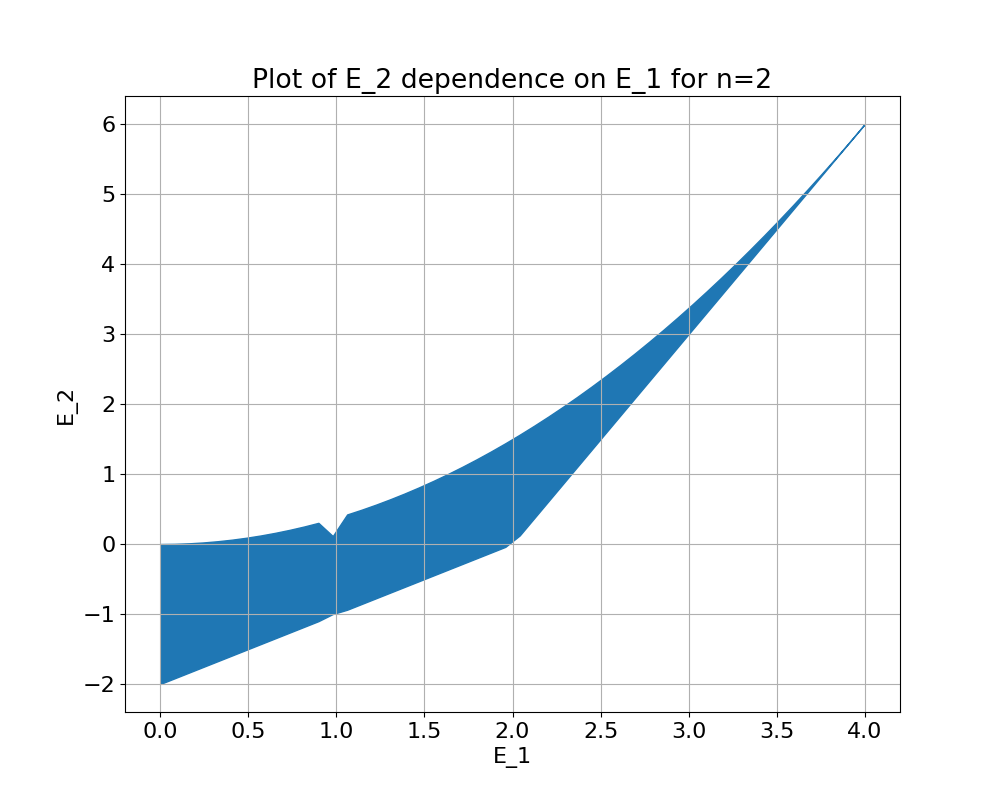

In [7]:
# Generate x values from 0 to 3
x_values = np.linspace(0, 4, 50)

min_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1, loc=0), x_values))
max_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1+n, loc=0), x_values))

min_y_values = [y.fun for y in min_y]
max_y_values = [y.fun*-1 for y in max_y]

font = {'size': 16}
plt.rc('font', **font)

plt.figure(figsize=(10, 8))
plt.fill_between(x_values, min_y_values, max_y_values, interpolate=True, color='C0')
#plt.plot(x_values, max_y_values, label='Max', color='C1')
#plt.plot(x_values, min_y_values, label='Min', color='C2')
#plt.axis([0, 7,-3, 15])

plt.title('Plot of E_2 dependence on E_1 for n=2')
plt.xlabel('E_1')
plt.ylabel('E_2')
plt.grid(True)
plt.savefig('niep_2_s1_s2.png', bbox_inches='tight')

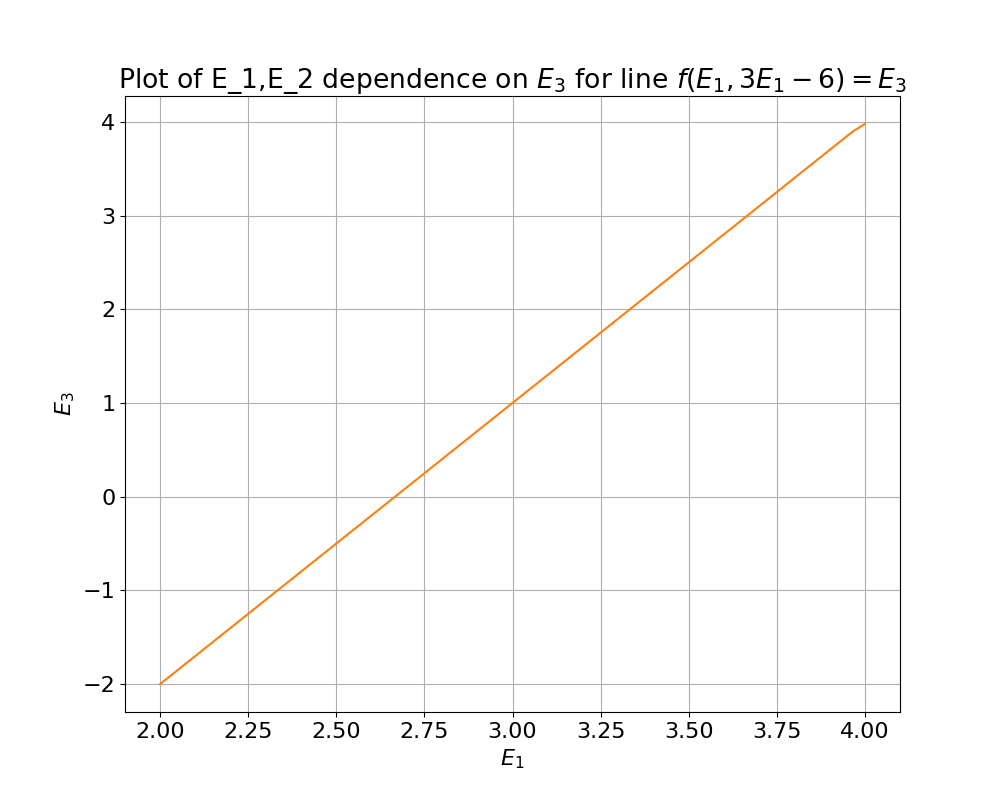

In [156]:
x_values = np.linspace(2, 4, 60)

min_y = list(starmap(functools.partial(run_function_with_constraints_and_double_equal, func_num=2, loc_1=0, loc_2=1), zip(x_values,  3*x_values-6)))
#max_y = list(starmap(functools.partial(run_function_with_constraints_and_double_equal, func_num=2+n, loc_1=0, loc_2=1), zip(0*x_values+1.5, x_values)))

min_y_values = [y.fun for y in min_y]
#max_y_values = [y.fun*-1 for y in max_y]

font = {'size': 16}
plt.rc('font', **font)
plt.figure(figsize=(10, 8))
#plt.fill_between(x_values, min_y_values, max_y_values, interpolate=True, color='C0')
#plt.plot(x_values, max_y_values, label='Max', color='C1')
plt.plot(x_values, min_y_values, label='Min', color='C1')

plt.title('Plot of E_1,E_2 dependence on $E_3$ for line $f(E_1,3E_1-6) = E_3$')
plt.xlabel('$E_1$')
plt.ylabel('$E_3$')
plt.grid(True)
plt.savefig('test.png', bbox_inches='tight')

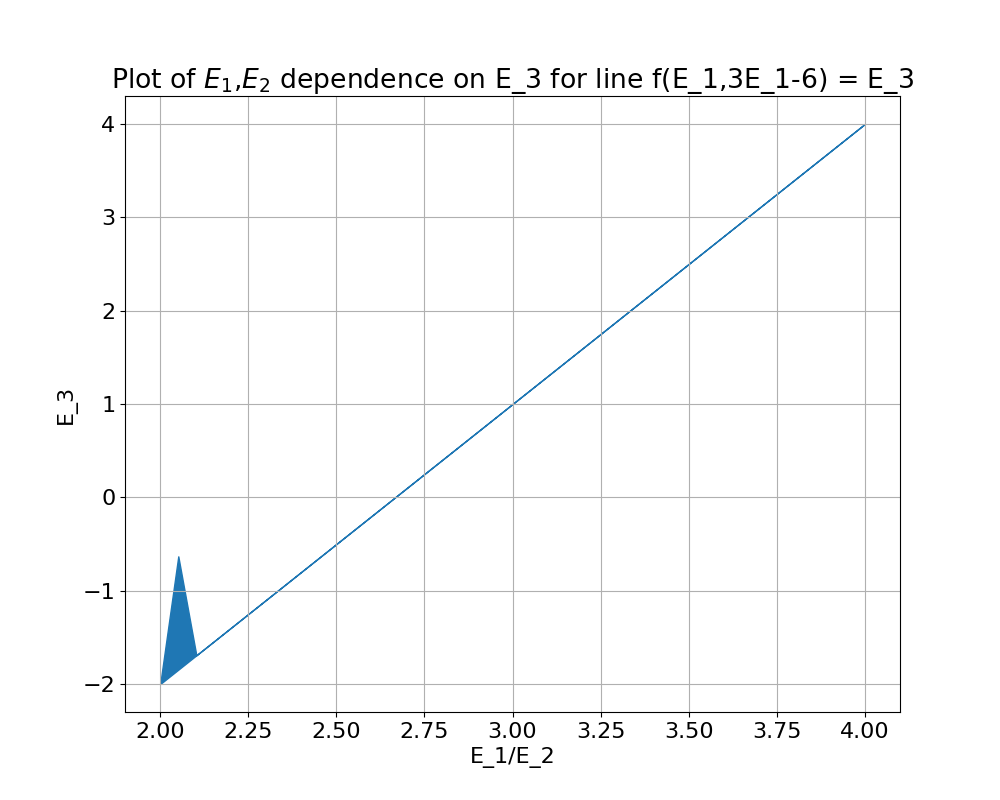

In [15]:
font = {'size': 16}
plt.rc('font', **font)
plt.figure(figsize=(10, 8))
plt.fill_between(x_values, min_y_values, max_y_values, interpolate=True, color='C0')

plt.title('Plot of $E_1$,$E_2$ dependence on E_3 for line f(E_1,3E_1-6) = E_3')
plt.xlabel('E_1/E_2')
plt.ylabel('E_3')
plt.grid(True)
plt.savefig('test.png', bbox_inches='tight')

         2
-0.3173 x + 1.545 x - 0.85
R-Value: 0.9999989812797598


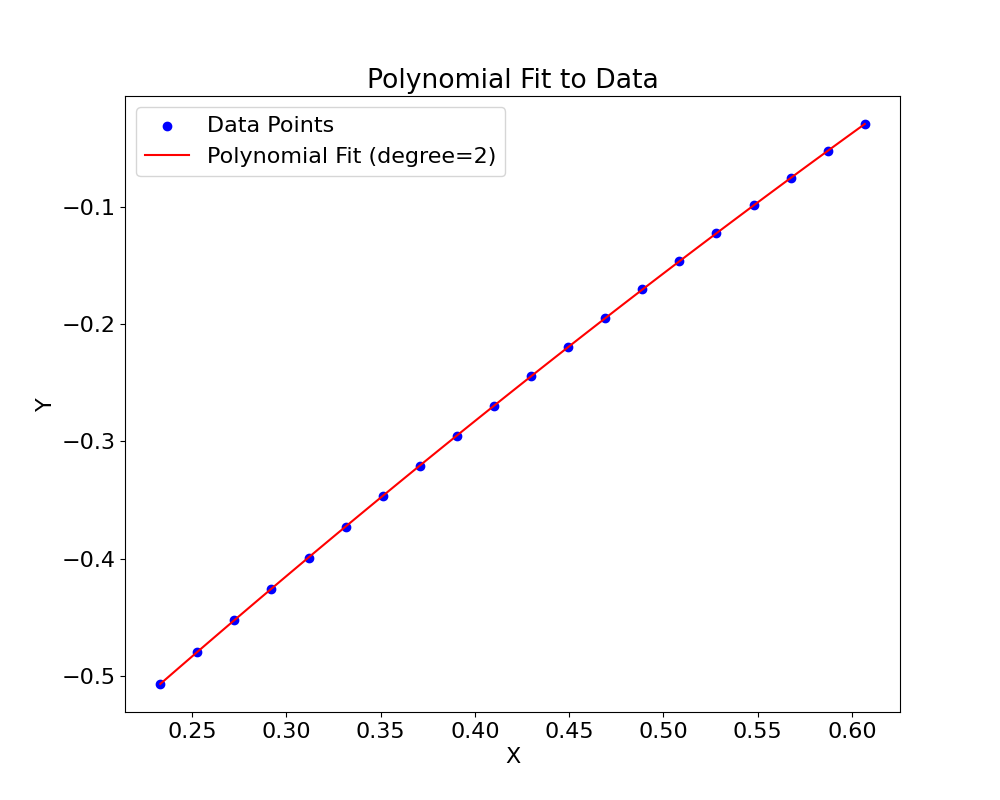

In [120]:
x = x_values[50:70]
y = min_y_values[50:70]


# Fit a polynomial of degree n (change n as needed)
degree = 2
coefficients = np.polyfit(x, y, degree)

# Generate a polynomial function from the coefficients
poly_func = np.poly1d(coefficients)
print(poly_func)

# Calculate R-squared
y_pred = poly_func(x)
residuals = y - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

print("R-Value:", r_squared)

# Generate values for plotting the fitted polynomial
x_fit = np.linspace(min(x), max(x), 100)
y_fit = poly_func(x_fit)

# Plotting the data points and the fitted polynomial
plt.close()
plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x_fit, y_fit, color='red', label=f'Polynomial Fit (degree={degree})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polynomial Fit to Data')
plt.legend()
plt.show()

In [38]:
def func_z(x, y):
    return run_function_with_constraints_and_double_equal(func_num=2, loc_1=3, val_1=x, loc_2=2, val_2=y).fun

def func_z_flipped(x, y):
    return -1*run_function_with_constraints_and_double_equal(func_num=2+n, loc_1=3, val_1=x, loc_2=2, val_2=y).fun

# Generate data points
x_values = np.linspace(-1, 1, 20)

min_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1, loc=3), x_values))
max_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1+n, loc=3), x_values))

min_y_values = [y.fun for y in min_y]
max_y_values = [y.fun*-1 for y in max_y]

# Create lists to store meshgrid points
X_mesh = []
Y_mesh = []

# Generate meshgrid points
i=0
for xi in x_values:
    y_vals = np.linspace(min_y_values[i], max_y_values[i], 15)
    i = i+1
    X_mesh.append(np.full_like(y_vals, xi))
    Y_mesh.append(y_vals)

X = np.concatenate(X_mesh)
Y = np.concatenate(Y_mesh)

print("XY Done")

#Z_flip = list(starmap(func_z_flipped, zip(X,Y)))
print("Z 1 Done")
Z = list(starmap(func_z, zip(X,Y)))
print("Z 2 Done")

XY Done
Z 1 Done


/home/ben/.local/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


KeyboardInterrupt: 

In [24]:
len(X)

2600

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (300,) and arg 2 with shape (1200,).

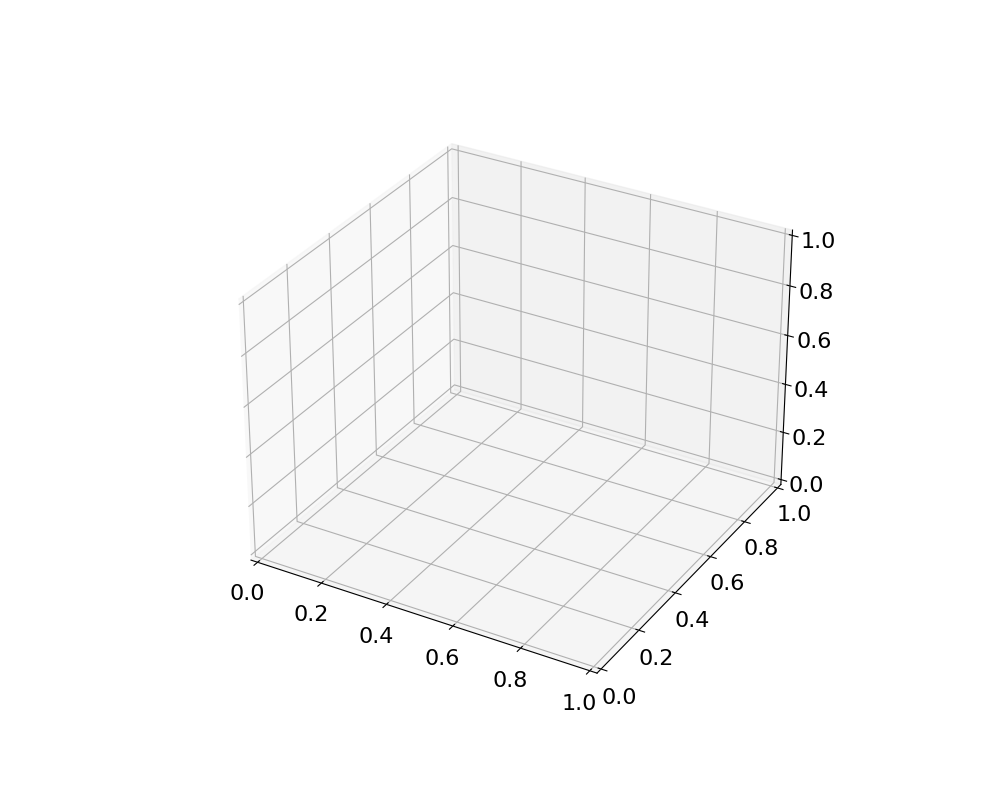

In [39]:
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.scatter(X, Y, Z, color='C0')

# Customize labels
ax.set_title('3D Surface Plot')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

Text(0.5, 0, 'Z axis')

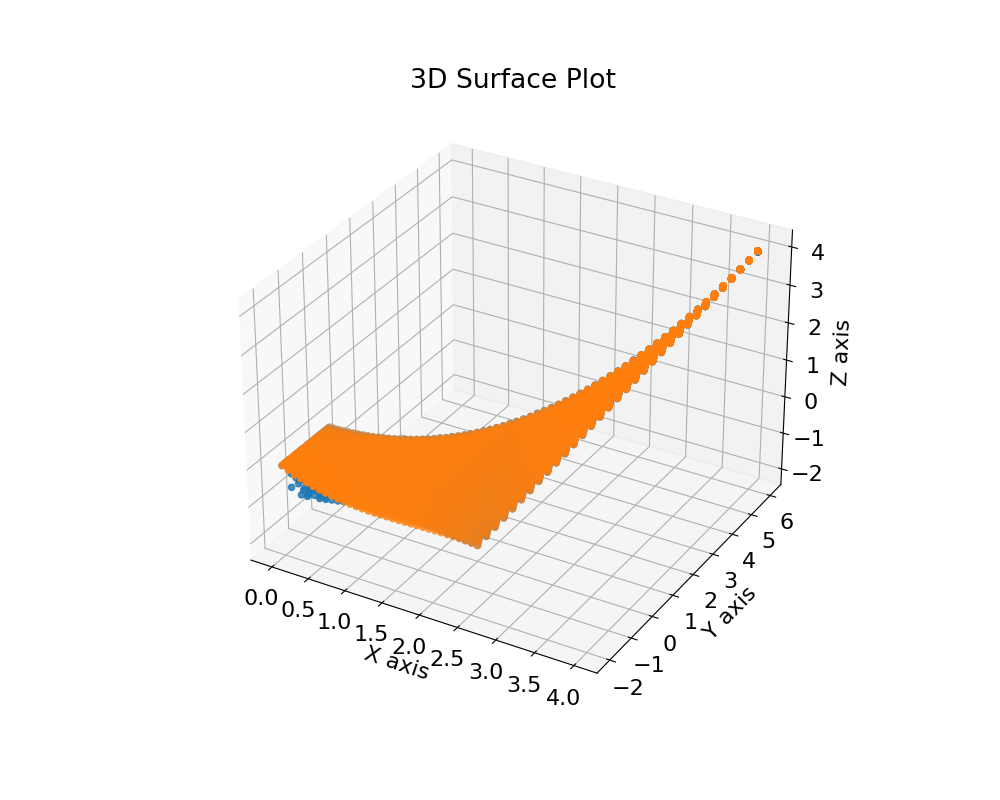

In [45]:
def poly_lower(z):
    x = z[0]
    y = z[1]
    if y <= 0:
        return -(x**3)/4 + x*y
    return x*y/2 - (1/8)*(x**2 - (8/3)*y)**(3/2) - (1/8)*x**3

poly_Z = list(map(poly_lower, zip(X,Y)))

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.scatter(X, Y, Z_bot, color='C0')
out_plot = ax.scatter(X, Y, poly_Z, color='C1')

# Customize labels
ax.set_title('3D Surface Plot')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

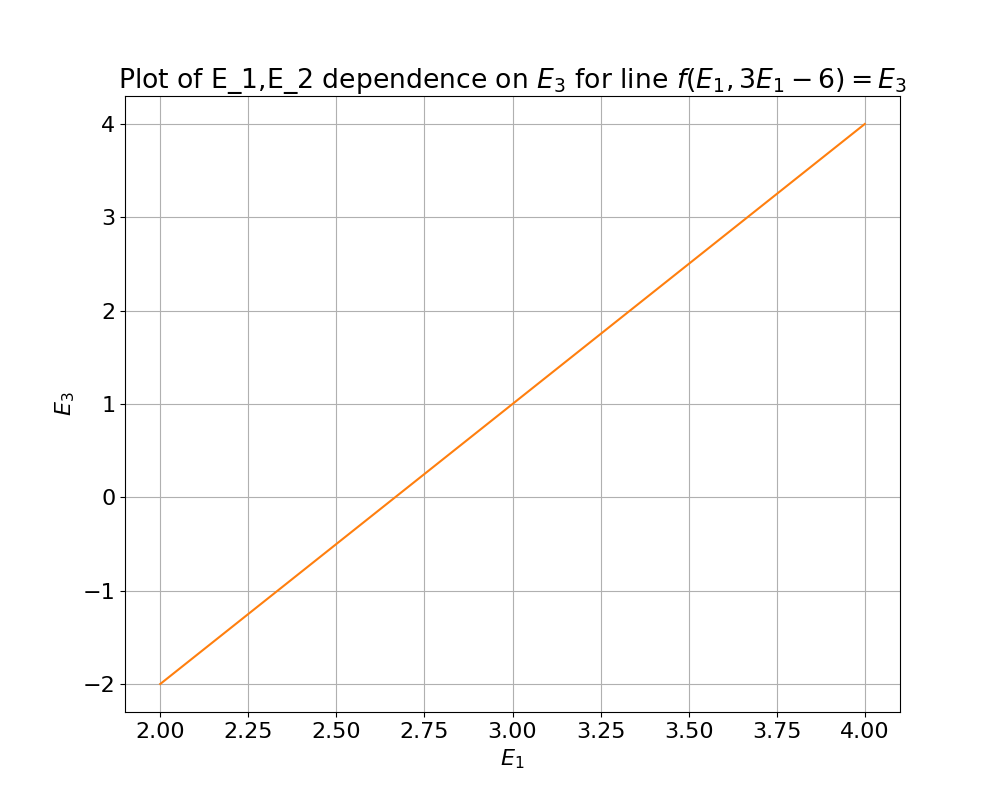

In [159]:
def poly_lower(x, y):
    return -(x**3)/4 + x**2 *y / 12 + 5*x*y / 6 - 2*y**2 / 9

x_values = np.linspace(2, 4, 90)

min_y = np.vectorize(poly_lower)(x_values,3*x_values - 6)

#max_y = list(starmap(functools.partial(run_function_with_constraints_and_double_equal, func_num=2+n, loc_1=0, loc_2=1), zip(0*x_values+1.5, x_values)))

min_y_values = [y for y in min_y]

font = {'size': 16}
plt.rc('font', **font)
plt.figure(figsize=(10, 8))
#plt.fill_between(x_values, min_y_values, max_y_values, interpolate=True, color='C0')
#plt.plot(x_values, max_y_values, label='Max', color='C1')
plt.plot(x_values, min_y_values, label='Min', color='C1')

plt.title('Plot of E_1,E_2 dependence on $E_3$ for line $f(E_1,3E_1-6) = E_3$')
plt.xlabel('$E_1$')
plt.ylabel('$E_3$')
plt.grid(True)
plt.savefig('test.png', bbox_inches='tight')

Text(0.5, 0, 'Z axis')

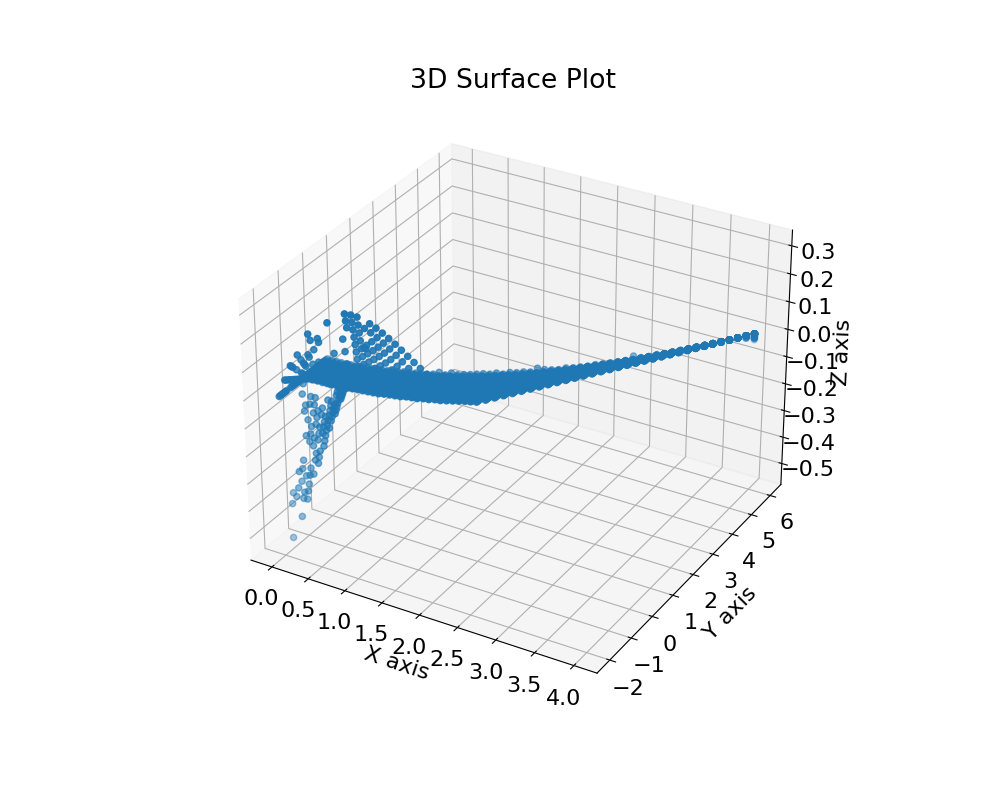

In [41]:
def poly_lower(x, y):
    if y <= 0:
        return -(x**3)/4 + x*y
    return x*y/2 - (1/8)*(x**2 - (8/3)*y)**(3/2) - (1/8)*x**3

poly_Z = np.vectorize(poly_lower)(X,Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.scatter(X, Y, Z_bot - poly_Z, color='C0')
#out_plot = ax.scatter(X, Y, poly_Z, color='C0')

# Customize labels
ax.set_title('3D Surface Plot')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

In [27]:
import pickle

with open('bot_niep_4_65x40.pkl', 'rb') as f:
    Z_bot = pickle.load(f)

with open('top_niep_4_65x40.pkl', 'rb') as f:
    Z_top = pickle.load(f)


Text(0.5, 0, '$E_3$')

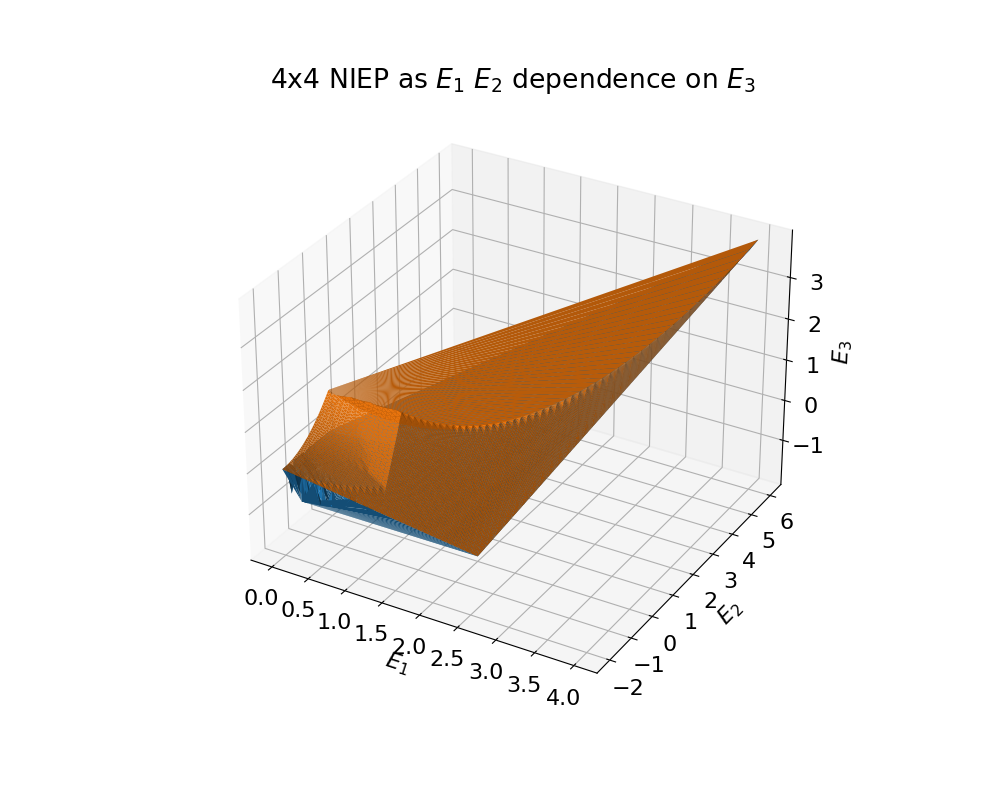

In [49]:
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.plot_trisurf(X, Y, Z_bot, color='C0')
out_plot = ax.plot_trisurf(X, Y, Z_top, color='C1')

# Customize labels
ax.set_title('4x4 NIEP as $E_1$ $E_2$ dependence on $E_3$')
ax.set_xlabel('$E_1$')
ax.set_ylabel('$E_2$')
ax.set_zlabel('$E_3$')

Text(0.5, 0, '$E_3$')

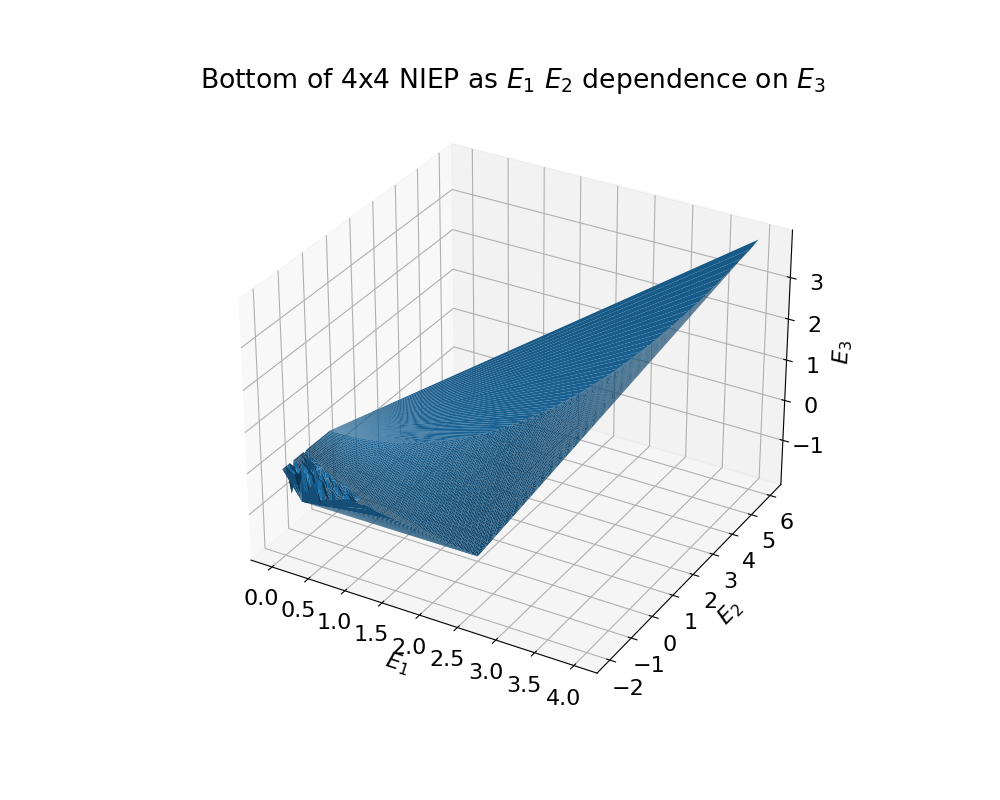

In [82]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.plot_trisurf(X, Y, Z_bot, color='C0', linewidth=0.2, antialiased=True)

ax.set_title('Bottom of 4x4 NIEP as $E_1$ $E_2$ dependence on $E_3$')
ax.set_xlabel('$E_1$')
ax.set_ylabel('$E_2$')
ax.set_zlabel('$E_3$')

/tmp/ipykernel_754456/362530653.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))


Text(0.5, 0, '$E_3$')

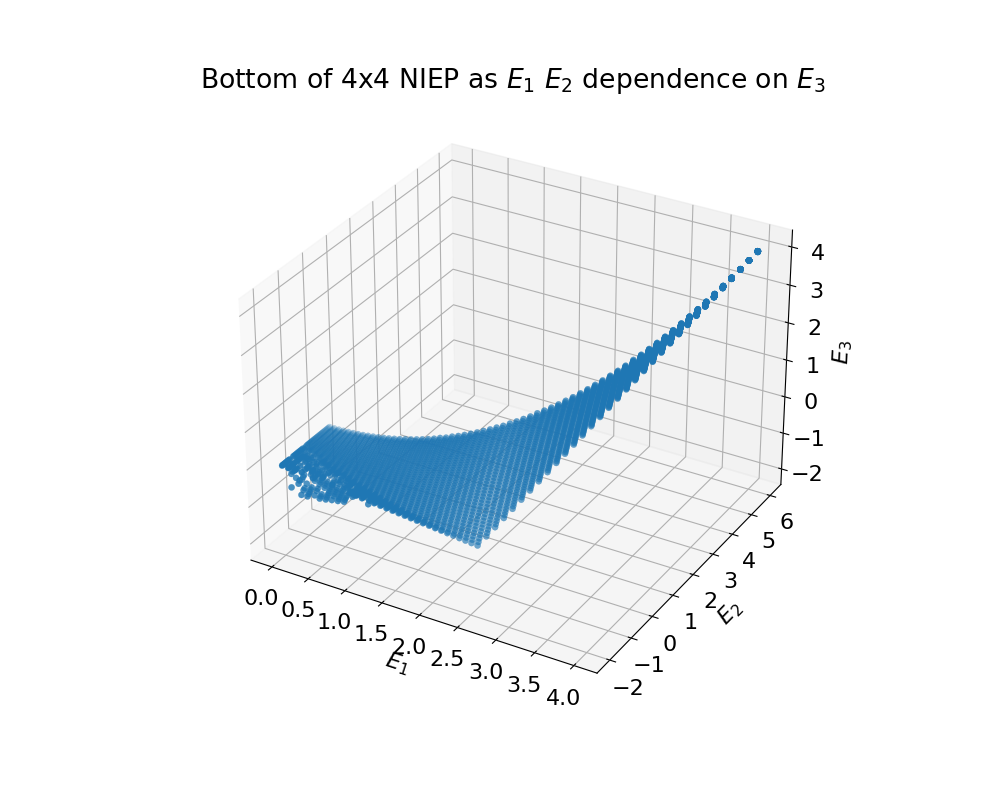

In [83]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.scatter(X, Y, Z_bot, color='C0', linewidth=0.2, antialiased=True)

ax.set_title('Bottom of 4x4 NIEP as $E_1$ $E_2$ dependence on $E_3$')
ax.set_xlabel('$E_1$')
ax.set_ylabel('$E_2$')
ax.set_zlabel('$E_3$')

Text(0.5, 0, '$E_3$')

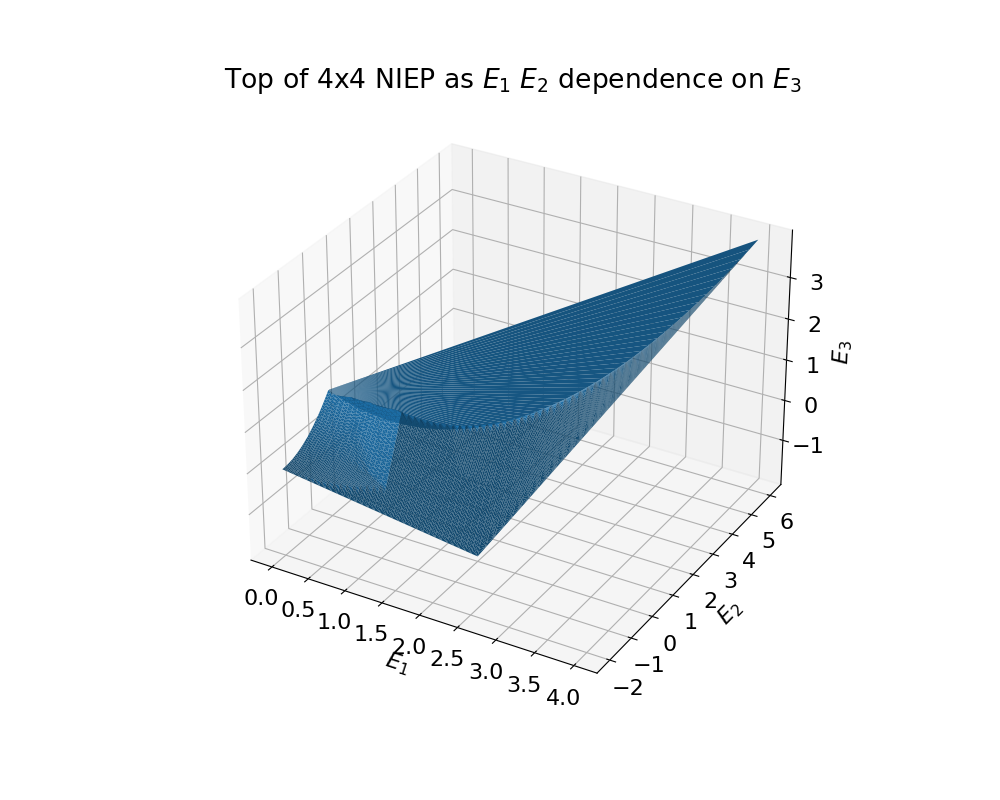

In [46]:
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.plot_trisurf(X, Y, Z_top, color='C0')

# Customize labels
ax.set_title('Top of 4x4 NIEP as $E_1$ $E_2$ dependence on $E_3$')
ax.set_xlabel('$E_1$')
ax.set_ylabel('$E_2$')
ax.set_zlabel('$E_3$')